sklearn 1.7.2 torch 2.8.0+cpu
device: cpu
Extracted (362, 64, 512) labels [ 90 272]

=== Fold 1/10 ===
ep01/40 tl=0.6054 trb=0.500 vlb=0.500 t=6.6s
ep02/40 tl=0.4697 trb=0.500 vlb=0.500 t=6.6s
ep03/40 tl=0.4314 trb=0.556 vlb=0.460 t=6.5s
ep04/40 tl=0.2508 trb=0.828 vlb=0.510 t=6.4s
ep05/40 tl=0.1919 trb=0.938 vlb=0.488 t=6.9s
ep06/40 tl=0.1017 trb=0.980 vlb=0.452 t=7.4s
ep07/40 tl=0.0371 trb=0.991 vlb=0.452 t=7.5s
ep08/40 tl=0.0632 trb=0.991 vlb=0.486 t=7.5s
ep09/40 tl=0.0307 trb=0.973 vlb=0.450 t=7.7s
ep10/40 tl=0.0143 trb=0.994 vlb=0.506 t=7.5s
ep11/40 tl=0.0090 trb=0.997 vlb=0.431 t=7.7s
ep12/40 tl=0.0034 trb=1.000 vlb=0.431 t=7.3s
 early stop
 >> fold 1 val_bal 0.5099206349206349

=== Fold 2/10 ===
ep01/40 tl=0.6168 trb=0.500 vlb=0.500 t=6.5s
ep02/40 tl=0.5708 trb=0.500 vlb=0.500 t=6.7s
ep03/40 tl=0.5070 trb=0.649 vlb=0.569 t=6.6s
ep04/40 tl=0.4410 trb=0.741 vlb=0.585 t=7.0s
ep05/40 tl=0.3998 trb=0.765 vlb=0.550 t=7.5s
ep06/40 tl=0.2752 trb=0.915 vlb=0.601 t=8.9s
ep07/40 tl=0.1594 

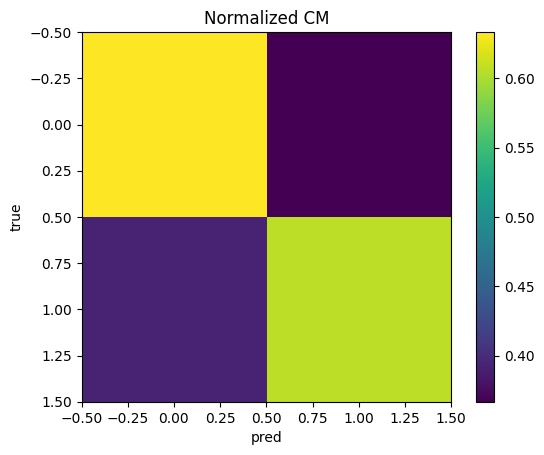

Per fold: [0.51  0.73  0.5   0.63  0.833 0.63  0.593 0.537 0.648 0.593]
Best fold: 5


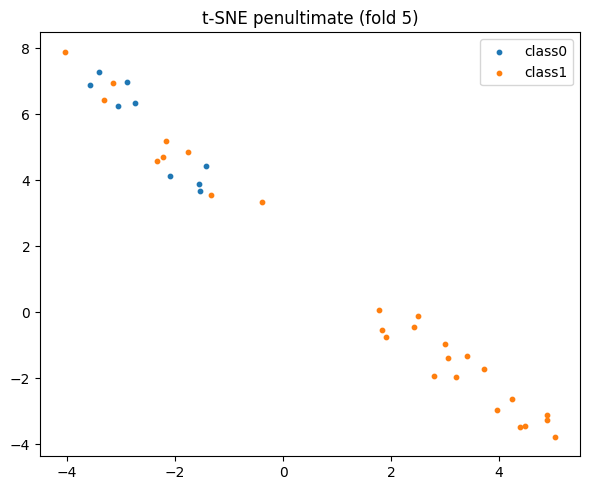

Done, models saved in balanced_cv_results


In [ ]:
# ------------------------------ FULL PIPELINE (FIXED FOR TORCH>=2.8) ------------------------------
import os, glob, numpy as np, time, torch, torch.nn as nn, matplotlib.pyplot as plt
import mne, sklearn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.manifold import TSNE
from packaging import version
from collections import Counter

print("sklearn", sklearn.__version__, "torch", torch.__version__)

# ------------------------------ DATA PATH ------------------------------
DATA_ROOT = 'bciciv2a/files'   # <-- edit if different
SUBJECT   = 'S001'
SUBJ_FOLDER = os.path.join(DATA_ROOT, SUBJECT)
assert os.path.exists(SUBJ_FOLDER), f"Subject folder not found: {SUBJ_FOLDER}"

# ------------------------------ DATA LOADER ------------------------------
def extract_physionet_subject(subject_folder, tmin=0.0, tmax=3.2, l_freq=0.5, h_freq=50.0, sfreq_target=160.0):
    edf_files = sorted(glob.glob(os.path.join(subject_folder, '*.edf')))
    all_X, all_y, ch_names = [], [], None
    nt = int((tmax - tmin) * sfreq_target)
    for ef in edf_files:
        raw = mne.io.read_raw_edf(ef, preload=True, verbose=False)
        raw.filter(l_freq, h_freq, verbose=False)
        if abs(raw.info['sfreq'] - sfreq_target) > 1e-3:
            raw.resample(sfreq_target, npad='auto', verbose=False)
        picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
        try: events, _ = mne.events_from_annotations(raw, verbose=False)
        except Exception: events=[]
        for ev in events:
            s=int(ev[0]); st=int(s+tmin*raw.info['sfreq']); en=int(s+tmax*raw.info['sfreq'])
            if st<0 or en>raw.n_times: continue
            d=raw.get_data(picks=picks,start=st,stop=en)
            if d.shape[1]!=nt:
                if d.shape[1]>nt: d=d[:,:nt]
                else: d=np.hstack([d,np.zeros((len(picks),nt-d.shape[1]))])
            lbl=0 if (int(ev[2])%2==0) else 1
            all_X.append(d); all_y.append(lbl)
        if ch_names is None and picks is not None:
            ch_names=[raw.ch_names[i] for i in picks]
    if len(all_X)==0:
        return np.zeros((0,len(picks) if picks is not None else 0,nt)),np.zeros((0,),int),ch_names
    return np.stack(all_X).astype(np.float32), np.array(all_y,int), ch_names

# ------------------------------ MODEL ------------------------------
class TFEMBlock(nn.Module):
    def __init__(self,nch,F=16,k_t=15,pool=False,pool_k=4,drop=0.25):
        super().__init__(); pad_t=(k_t-1)//2
        self.conv=nn.Conv2d(1,F,(1,k_t),padding=(0,pad_t))
        self.bn=nn.BatchNorm2d(F); self.pw=nn.Conv2d(F,1,1)
        self.pool=nn.AvgPool2d((1,pool_k)) if pool else None
        self.elu=nn.ELU(); self.drop=nn.Dropout(drop)
    def forward(self,x):
        x=self.conv(x.unsqueeze(1)); x=self.bn(x); x=self.elu(x); x=self.pw(x)
        if self.pool: x=self.pool(x)
        return self.drop(x).squeeze(1)

class CARM(nn.Module):
    def __init__(self,Wref,tdim,drop=0.25):
        super().__init__(); self.Wref=Wref
        self.Theta=nn.Parameter(torch.randn(tdim,tdim)*0.01)
        self.elu=nn.ELU(); self.drop=nn.Dropout(drop)
    def forward(self,x):
        h=torch.einsum('ij,bjf->bif',self.Wref,x)
        o=torch.einsum('bif,fg->big',h,self.Theta)
        return self.drop(self.elu(o))

class EEG_ARNN(nn.Module):
    def __init__(self,nch,T0,ncls=2,F=16,pool_k=4,rho=0.001):
        super().__init__(); self.rho=rho
        W0=torch.ones(nch,nch)-torch.eye(nch)
        Wt=W0+torch.eye(nch)
        D=Wt.sum(dim=1); Dinv=torch.diag(1.0/torch.sqrt(D+1e-12))
        self.W=nn.Parameter(Dinv@Wt@Dinv)
        self.tf1=TFEMBlock(nch,F=F); self.c1=CARM(self.W,tdim=T0)
        self.tf2=TFEMBlock(nch,F=F,pool=True,pool_k=pool_k); T2=T0//pool_k
        self.c2=CARM(self.W,tdim=T2)
        self.tf3=TFEMBlock(nch,F=F,pool=True,pool_k=pool_k); T3=T2//pool_k
        self.c3=CARM(self.W,tdim=T3)
        self.fuse=nn.Conv2d(1,16,(nch,1)); self.bn=nn.BatchNorm2d(16)
        self.elu=nn.ELU(); self.drop=nn.Dropout(0.25)
        self.fc=nn.Linear(16*T3,ncls)
    def forward(self,x):
        x=self.tf1(x);x=self.c1(x);x=self.tf2(x);x=self.c2(x);x=self.tf3(x);x=self.c3(x)
        x=self.fuse(x.unsqueeze(1));x=self.bn(x);x=self.elu(x);x=self.drop(x)
        b,o,t=x.squeeze(2).shape; return self.fc(x.squeeze(2).view(b,o*t))

# ------------------------------ TRAIN HELPERS ------------------------------
def train_epoch(m,ldr,opt,dev,crit,rho):
    m.train(); tot=0;n=0
    for xb,yb in ldr:
        xb,yb=xb.to(dev),yb.to(dev);opt.zero_grad()
        o=m(xb);l=crit(o,yb);l.backward();opt.step()
        with torch.no_grad():
            if m.W.grad is not None:
                m.W.data=(1-rho)*m.W.data-rho*m.W.grad.data
                m.W.grad.zero_()
        tot+=l.item()*xb.size(0);n+=xb.size(0)
    return tot/max(1,n)

def eval_model(m,ldr,dev):
    m.eval();p=[];y=[]
    with torch.no_grad():
        for xb,yb in ldr:
            xb,yb=xb.to(dev),yb.to(dev)
            o=m(xb);p.append(o.argmax(1).cpu().numpy());y.append(yb.cpu().numpy())
    return np.concatenate(p),np.concatenate(y)

# ------------------------------ CONFIG ------------------------------
EPOCHS=40;BATCH=32;LR=1e-3;PATIENCE=8;N_SPLITS=10
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUTDIR='balanced_cv_results';os.makedirs(OUTDIR,exist_ok=True)
print("device:",DEVICE)

# ------------------------------ LOAD DATA ------------------------------
X,y,chs=extract_physionet_subject(SUBJ_FOLDER)
print("Extracted",X.shape,"labels",np.bincount(y))

# ------------------------------ TRAINING ------------------------------
skf=StratifiedKFold(n_splits=N_SPLITS,shuffle=True,random_state=42)
all_p,all_t=[],[];folds=[]
for fold,(tr,vl) in enumerate(skf.split(X,y),1):
    print(f"\n=== Fold {fold}/{N_SPLITS} ===")
    Xtr,Xvl=X[tr].copy(),X[vl].copy();ytr,yvl=y[tr].copy(),y[vl].copy()
    mC=Xtr.mean((0,2),keepdims=True);sC=Xtr.std((0,2),keepdims=True)+1e-6
    Xtr=(Xtr-mC)/sC;Xvl=(Xvl-mC)/sC
    cls=np.bincount(ytr);sw=(1/(cls+1e-12))[ytr].astype(np.float32)
    samp=WeightedRandomSampler(torch.from_numpy(sw),num_samples=len(sw),replacement=True)
    trL=DataLoader(TensorDataset(torch.tensor(Xtr),torch.tensor(ytr)),batch_size=BATCH,sampler=samp)
    vlL=DataLoader(TensorDataset(torch.tensor(Xvl),torch.tensor(yvl)),batch_size=BATCH,shuffle=False)
    cw=(len(ytr)/(len(np.unique(y))* (cls+1e-12))).astype(np.float32)
    cw_t=torch.tensor(cw).to(DEVICE)
    m=EEG_ARNN(nch=X.shape[1],T0=X.shape[2],ncls=len(np.unique(y))).to(DEVICE)
    opt=torch.optim.Adam([p for n,p in m.named_parameters() if n!='W'],lr=LR)
    crit=nn.CrossEntropyLoss(weight=cw_t)
    try:
        sch=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='max',factor=0.5,patience=3)
    except TypeError:
        sch=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='max',factor=0.5,patience=3)
    best=-1;wait=0
    for ep in range(1,EPOCHS+1):
        t0=time.time()
        tl=train_epoch(m,trL,opt,DEVICE,crit,m.rho)
        p1,y1=eval_model(m,trL,DEVICE);p2,y2=eval_model(m,vlL,DEVICE)
        tb=balanced_accuracy_score(y1,p1);vb=balanced_accuracy_score(y2,p2)
        sch.step(vb)
        print(f"ep{ep:02d}/{EPOCHS} tl={tl:.4f} trb={tb:.3f} vlb={vb:.3f} t={time.time()-t0:.1f}s")
        if vb>best+1e-4:
            best=vb;wait=0
            torch.save(m.state_dict(),os.path.join(OUTDIR,f'best_fold{fold}.pth'))
        else:
            wait+=1
            if wait>=PATIENCE:
                print(" early stop");break
    m.load_state_dict(torch.load(os.path.join(OUTDIR,f'best_fold{fold}.pth'),map_location=DEVICE))
    p,yv=eval_model(m,vlL,DEVICE)
    print(" >> fold",fold,"val_bal",balanced_accuracy_score(yv,p))
    np.savez_compressed(os.path.join(OUTDIR,f'fold{fold}_preds.npz'),preds=p,trues=yv)
    all_p.append(p);all_t.append(yv);folds.append(balanced_accuracy_score(yv,p))

# ------------------------------ RESULTS ------------------------------
aP,aT=np.concatenate(all_p),np.concatenate(all_t)
print("\nBalanced acc:",balanced_accuracy_score(aT,aP))
cm=confusion_matrix(aT,aP)
print("CM:\n",cm)
plt.imshow(cm.astype(float)/(cm.sum(1,keepdims=True)+1e-12))
plt.title("Normalized CM");plt.xlabel("pred");plt.ylabel("true");plt.colorbar();plt.show()
print("Per fold:",np.round(folds,3))

# ------------------------------ T-SNE ------------------------------
bi=int(np.argmax(folds))+1
print("Best fold:",bi)
for f,(tr,vl) in enumerate(StratifiedKFold(n_splits=N_SPLITS,shuffle=True,random_state=42).split(X,y),1):
    if f==bi:break
Xvl,yvl=X[vl].copy(),y[vl].copy()
mC=X[tr].mean((0,2),keepdims=True);sC=X[tr].std((0,2),keepdims=True)+1e-6
Xvl=(Xvl-mC)/sC
m=EEG_ARNN(nch=X.shape[1],T0=X.shape[2],ncls=len(np.unique(y))).to(DEVICE)
m.load_state_dict(torch.load(os.path.join(OUTDIR,f'best_fold{bi}.pth'),map_location=DEVICE))
m.eval();fL=[]
def hook(_,inp,out):fL.append(inp[0].detach().cpu().numpy())
h=m.fc.register_forward_hook(hook)
vlL=DataLoader(TensorDataset(torch.tensor(Xvl),torch.tensor(yvl)),batch_size=64)
with torch.no_grad():
    for xb,yb in vlL:_=m(xb.to(DEVICE))
h.remove();fL=np.vstack(fL)
tsArgs=dict(n_components=2,perplexity=min(30,len(yvl)//3),random_state=42)
tsArgs["max_iter" if version.parse(sklearn.__version__)>=version.parse("1.6") else "n_iter"]=1000
Z=TSNE(**tsArgs).fit_transform(fL)
plt.figure(figsize=(6,5))
for lbl in np.unique(yvl):plt.scatter(Z[yvl==lbl,0],Z[yvl==lbl,1],s=10,label=f'class{lbl}')
plt.legend();plt.title(f"t-SNE penultimate (fold {bi})");plt.tight_layout();plt.show()
print("Done, models saved in",OUTDIR)
